In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.data.key_dataset import remove_overlaps, select_keys, create_windows, KeyDataset
from src.data.filter import Filter

from src.data.utils import bipolar_conversion, load_data, key_counts, load_data_deprecated
from src.visualization.visualize import layout

from src.utils import load_config
from src.models.keydecoder import KeyDecoder
from src.models.rtdecoder import RTDecoder
from src.models.train import train
from src.models.utils import Experiment

import importlib
import operator
from functools import reduce

%load_ext autoreload
%autoreload 2


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
typing_test_layout = ['f', 'a', 's', 'd', ' ', 'j', 'k', 'l', ';']
pacman_keys = {65362: 'up', 65364: 'down', 65361: 'left', 65363: 'right'}
pacman_layout = [chr(key) for key in pacman_keys]
# typing_test_layout = ['q', 'a', 'z', 'w', 's', 'x', 'e', 'd', 'c', 'r', 'f', 'v', 't', 'g', 'b']
#typing_test_layout = ['a', 's', 'd', 'f']
window_pre = 480
window_post = 480
subwindow_len = 480

In [3]:
gesture_layout = [0, 1, 2, 3]
left_layout = ['a', 's', 'd', 'f']
right_layout = ['j', 'k', 'l', ';']
typing_layout = ['d', 'f', 'g', 'h']
full_layout = ['a', 's', 'd', 'f', 'j', 'k', 'l', ';', ' ']
ol_testing = [0, 1, 2, 3]
layout = ['d', 'f', 'g', 'h']
comb_layout = ['a', 's', 'd', 'f', 'g', 'b']

In [6]:
data_dir = "/home/john/rumi/data/"

#expt_names = ["Shreyas-Kaasyap_2023-08-04-1255_Open-Loop-Typing-Task",
#              "Shreyas-Kaasyap_2023-07-31-1407_Open-Loop-Typing-Task",
#              "Shreyas-Kaasyap_2023-08-01-1528_Open-Loop-Typing-Task"]

#expt_names = ["Nima-Hadidi_2023-09-26-1649_Gesture-Decoding-Task"]
# expt_names = ["NIma_2023-08-31-1833_Gesture-Decoding-Task"]
#expt_names = ["Nima_2023-08-25-2008_Gesture-Decoding-Task"]
#expt_names = ["Shreyas-Kaasyap_2023-08-24-1437_Open-Loop-Typing-Task"]
#expt_names = ["Shreyas_2023-08-24-1709_Open-Loop-Typing-Task"]
#expt_names = ["Shreyas_2023-08-28-1546_Open-Loop-Typing-Task"]

#expt_names = ["Shreyas_2023-08-29-1604_Open-Loop-Typing-Task"]
#expt_names = ["Jaco_2023-10-24-1911_Open-Loop-Typing-Task"]
#expt_names = ["Jacob_2023-10-30-1648_Open-Loop-Typing-Task"]
#expt_names = ["OL_TESTING_2023-11-08-0051_Closed-Loop-Typing-Task"]
#expt_names = ["OL_TESTING_2023-11-08-0122_Closed-Loop-Typing-Task"]
#expt_names = ["Jacob_2023-11-17-1130_Open-Loop-Typing-Task"]
#expt_names = ["jacob_cl_test_2023-11-17-1218_Closed-Loop-Typing-Task"]
#expt_names = ["jacob_cl_test_2023-11-17-1230_Closed-Loop-Typing-Task"]
#expt_names = ["jacob_cl_test_2023-11-17-1441_Closed-Loop-Typing-Task"]
#expt_names = ["Shreyas_2023-11-20-1244_Open-Loop-Typing-Task"]
#expt_names = ["Jacob_2023-11-29-1425_Open-Loop-Typing-Task"]
#expt_names = ["E1_2024-01-11-1345_Open-Loop-Typing-Task", "E1_2024-01-11-1426_Open-Loop-Typing-Task"]
# expt_names = ["E1_2024-01-11-1426_Open-Loop-Typing-Task"]
#expt_names = ["E1_2024-01-11-1500_Open-Loop-Typing-Task"]
#expt_names = ["Jacob_2023-11-29-1425_Open-Loop-Typing-Task"]
#expt_names = ["test_2024-01-17-2359_Open-Loop-Typing-Task"]
#expt_names = ["E1_2024-01-18-1401_Open-Loop-Typing-Task"]
# expt_names = ["jacob_2024-01-19-1448_Open-Loop-Typing-Task"]
#expt_names = ["Jacob_2023-11-29-1425_Open-Loop-Typing-Task"]
# expt_names = ["Jacob_2024-02-22-1550_Open-Loop-Typing-Task"]
# expt_names = ["Shreyas_2024-07-03-1510_Rhythm-Game-Typing-Task"]
#expt_names = ["Jacob_test_2024-02-28-1435_Rhythm-Game-Typing-Task"]
expt_names = ["Derek_2024-07-11-1443_Rhythm-Game-Typing-Task"]
# expt_names = ["kenfu_2024-04-08-1718_Open-Loop-Typing-Task"]

def get_data(expt_list, layout):
    datasets = []

    for expt_name in expt_names:
        key_fname = data_dir + expt_name + "/data_streams/key_stream.bin"
        emg_fname = data_dir + expt_name + "/data_streams/emg_stream.bin"

        key_data = load_data(key_fname)
        emg_data = load_data(emg_fname)
        emg_names = ['emgbuffer'] + list(emg_data.dtype.names)[1:]
        key_names = ['keybuffer'] + list(key_data.dtype.names)[1:]
        emg_data.dtype.names = emg_names
        key_data.dtype.names = key_names
        
#         print(key_data[key_data['keybuffer'][:, 0] != 0])

        emg_stream = emg_data['emgbuffer']
        #print(emg_data['filterbuffer'].shape, "hi", emg_data['emgbuffer'].shape)
        
        print(emg_data.shape[0])

        dataset = KeyDataset(emg_stream, key_data, layout, window_pre, window_post, subwindow_len,
                              start_channel=1, 
                              end_channel=65, bipolar=False, avg_ref=True, binary=False,
                             include_blanks=False,
                             limit_blanks=False,
                              filter_params=None)

        datasets.append(dataset)
        #print(key_data[:50])
        
        
    full = reduce(operator.add, datasets)
    full.print_counts()
    data = full.to_numpy(include_full_windows=True)
    return data

In [7]:
data = get_data(expt_names, comb_layout)
print(data.dtype)
# print(np.unique(full_dataset.y))
# data['key_label'][np.where(data['key_label'] == 65364)] = 65362
# full_dataset.balance_classes(time_shift=False, add_noise=True)

#1698958653619074478,

2997017
Removed 0 out of 0 keypresses.


IndexError: index 2 is out of bounds for axis 1 with size 2

In [17]:
data['key_label']

array([], dtype=int64)

IndexError: index 0 is out of bounds for axis 0 with size 0

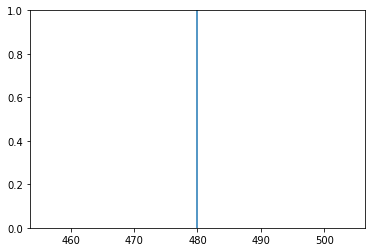

In [19]:
y = data['full_windows']
x = np.arange(0, 480*2)
for i in range(0, 300):
    #if(chr(data['key_label'][i]) == ';'):
    plt.figure(i)
    #plt.axvline(x=340, color='black')
    #plt.axvline(x=660, color='black')
#     plt.title(chr(int(data['key_label'][i])))
    #plt.axvline(x=1240)
    #plt.axvline(x=760)
    #plt.axvline(x=480)
    #plt.axvline(x=800)
    #plt.axvline(x=1000)
    plt.axvline(x=480)
    for j in range(0, 32):
        plt.plot(x, y[i, :, j])
    plt.show()

In [ ]:
y = data['full_windows']
x = np.arange(0, 2000)
for i in range(0, 700):
    #if(chr(data['key_label'][i]) == ';'):
    plt.figure(i)
    #plt.axvline(x=340, color='black')
    #plt.axvline(x=660, color='black')
    #plt.title((int(data['key_label'][i])))
    plt.axvline(x=680)
    plt.axvline(x=1000)
    for j in range(0, 16):
        plt.plot(x, y[i, :, j])

In [ ]:
y = data['full_windows']
x = np.arange(0, 960)
for i in range(0, 700):
    if(chr(data['key_label'][i]) != ';'):
        continue
    plt.figure(i)
    #plt.axvline(x=340, color='black')
    #plt.axvline(x=660, color='black')
    #plt.title((int(data['key_label'][i])))
    #plt.axvline(x=520, color = 'black')
    #plt.axvline(x=1000, color = 'black')
    for j in range(0, 32):
        plt.plot(x, y[i, :, j])
    plt.show()

In [ ]:
print(data.shape)

In [ ]:
from sklearn.decomposition import FastICA
fICA = FastICA(n_components = 8, random_state = 0, whiten = 'unit-variance')

In [60]:
emg_data = np.reshape(data['emg_windows'], (-1, 16))
full_data = np.reshape(data['full_windows'], (-1, 16))

In [61]:
data_transformed = fICA.fit_transform(emg_data)
data_transformed_full = fICA.fit_transform(full_data)

In [62]:
data_transformed.shape
data_transformed = np.reshape(data_transformed, (-1, 320, 8))
data_transformed_full = np.reshape(data_transformed_full, (-1, 480, 8))
data_transformed.shape
#type(data_transformed)(
type(data)
new_data = np.zeros(531, dtype=[('full_windows', '<f8', (480, 8)), ('emg_windows', '<f8', (320, 8)), ('key_label', '<i8')])

In [63]:
new_data['emg_windows'] = data_transformed
new_data['full_windows'] = data_transformed_full
new_data['key_label'] = data['key_label']


In [ ]:
print(new_data.dtype)

In [20]:
def convert(stream):
    mavstream = []
    for i in range(0, stream.shape[0], 80):
        cur = stream[i:i+80]
        tot = 0
        for j in cur:
            tot += abs(j)
        tot = tot/80
        mavstream.append(tot)
    return np.array(mavstream)

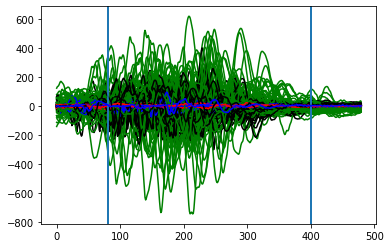

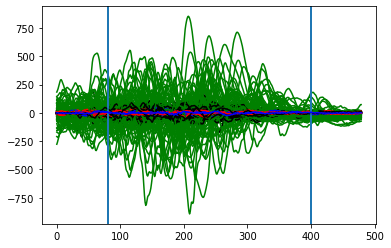

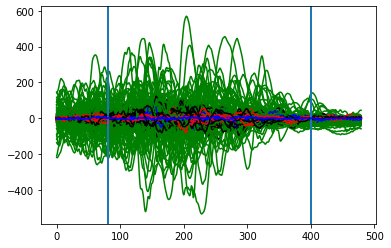

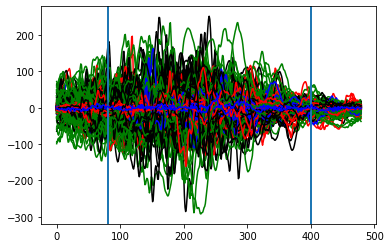

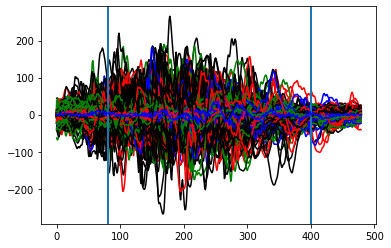

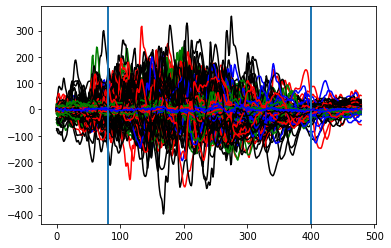

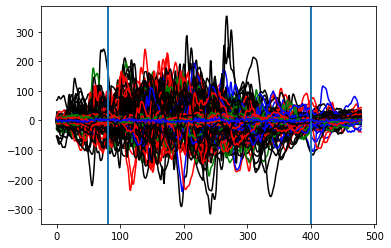

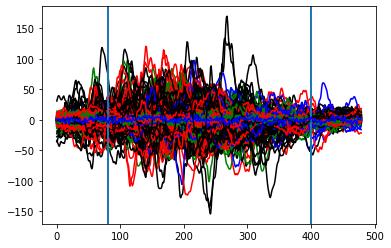

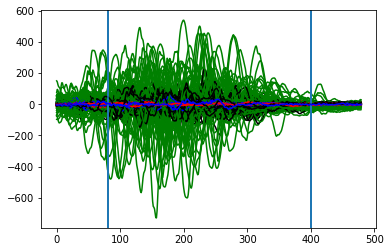

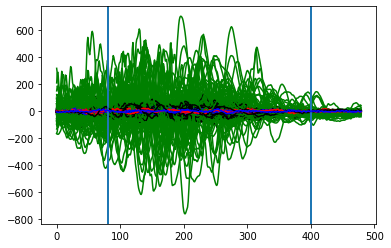

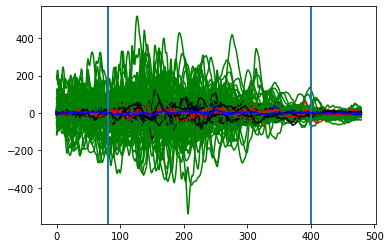

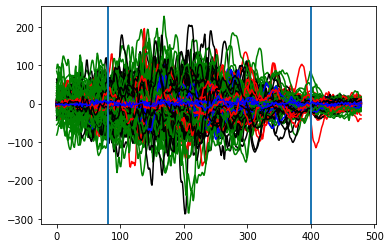

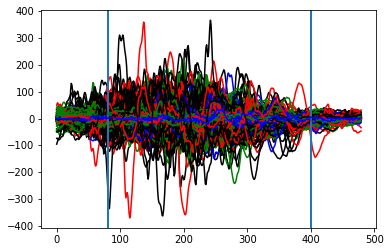

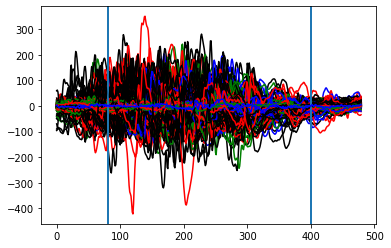

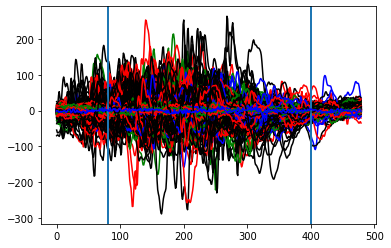

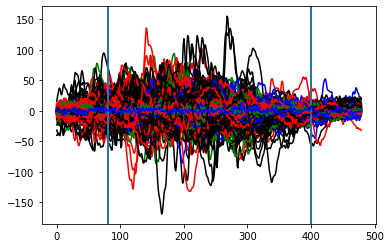

In [10]:
x = np.arange(0, (window_pre+window_post))

avg = []
count = 0

for i in range(0, 300):
    for j in range(0,16):
        plt.figure(j)
        plt.axvline(x = 80)
        plt.axvline(x = 400)
        y = data['full_windows'][i][:, j]
        #y = convert(y)
        if(data['key_label'][i] == 97):
            #pass
            plt.plot(x, y, color = 'blue')
            #avg = y
            #count += 1
        if(data['key_label'][i] == 115):
            #pass
            plt.plot(x, y, color = 'green')
        if(data['key_label'][i] == 100):
            #pass
            plt.plot(x, y, color = 'red')
        if(data['key_label'][i] == 102):
            #pass
            plt.plot(x, y, color = 'black')
            
#plt.plot(x, avg, color = 'black')

In [28]:
converted_stream = []
for i in range(0, data['key_label'].shape[0]):
    for j in range(0, 16):
        converted_stream.append(convert(data['full_windows'][i][:, j]))
        
converted_stream = np.array(converted_stream)

converted_stream = np.reshape(converted_stream, (data['key_label'].shape[0], 16, -1))

converted_stream = np.swapaxes(converted_stream, 1, 2)

print(converted_stream.shape)

data['emg_windows'] = converted_stream

(628, 6, 16)


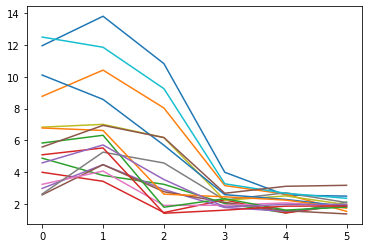

In [30]:
z = data['emg_windows'][3]
plt.plot(np.arange(0, 6), z)

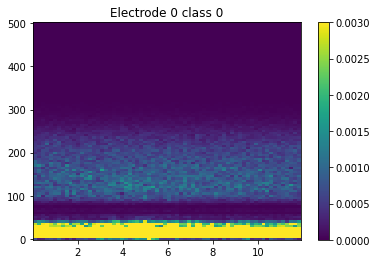

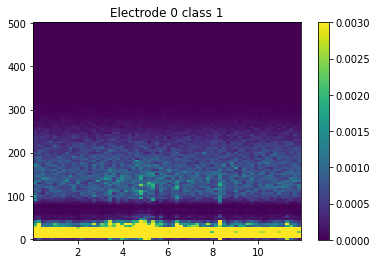

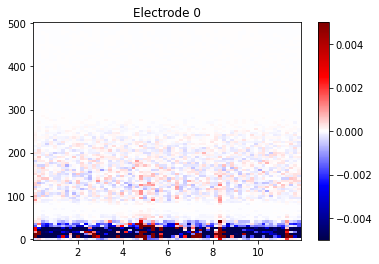

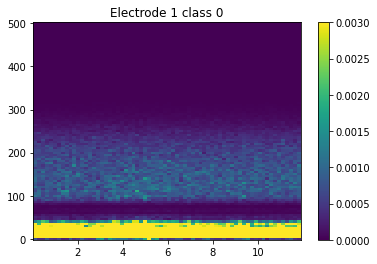

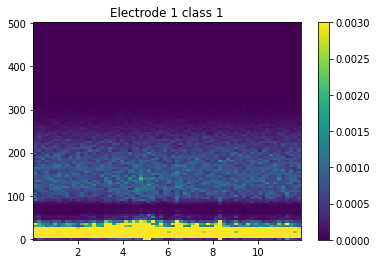

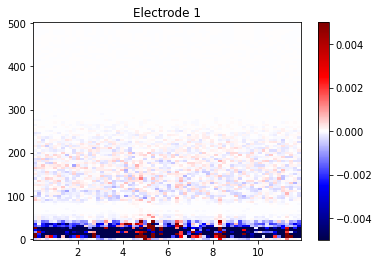

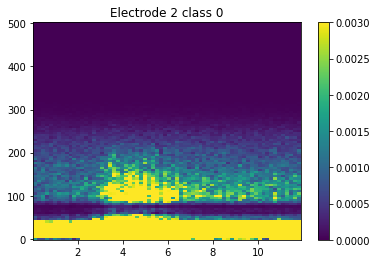

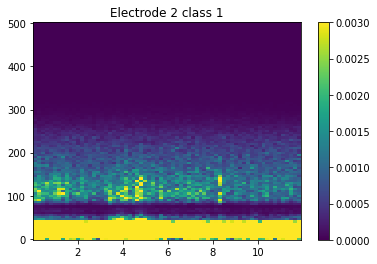

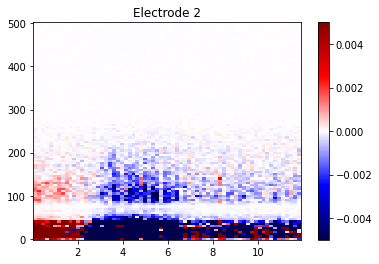

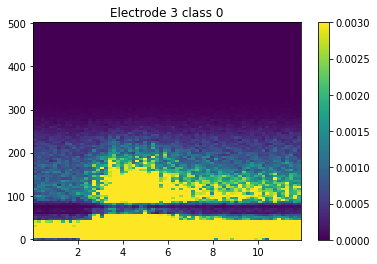

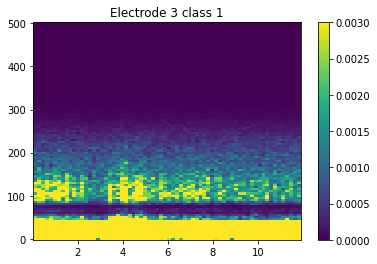

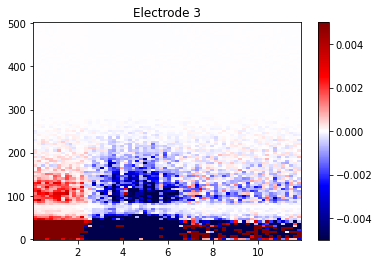

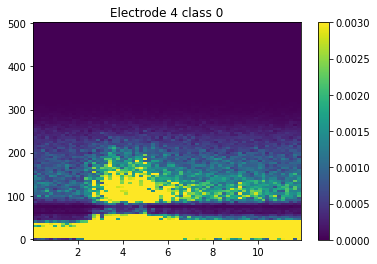

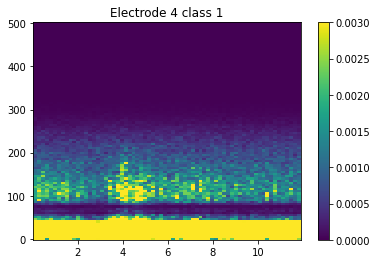

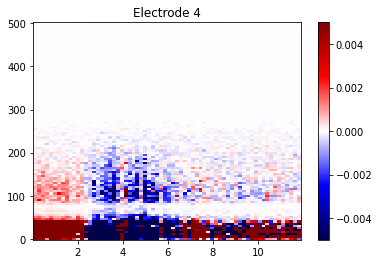

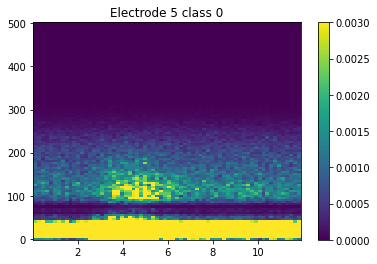

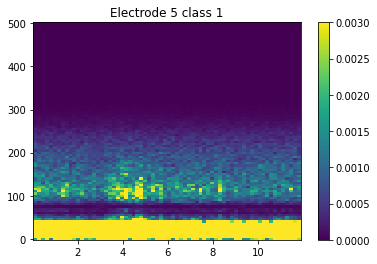

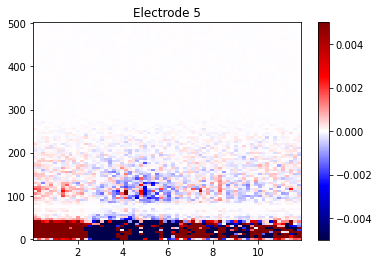

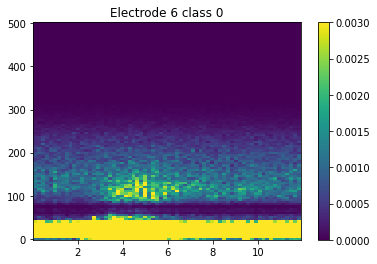

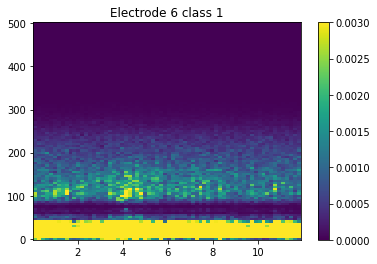

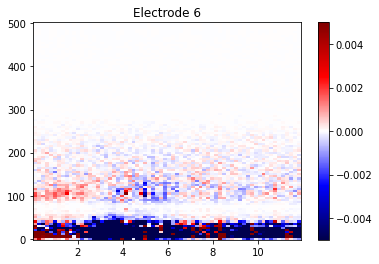

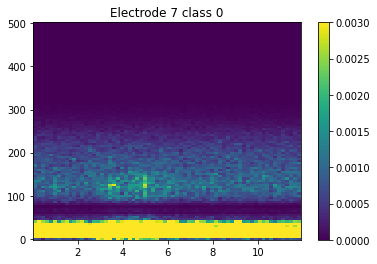

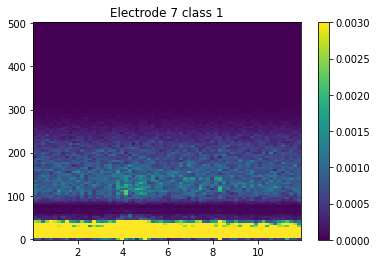

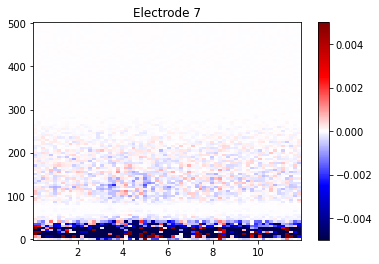

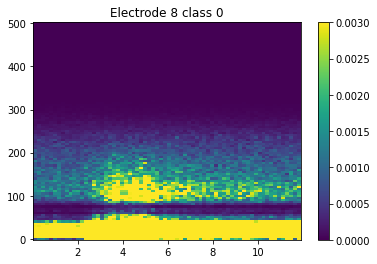

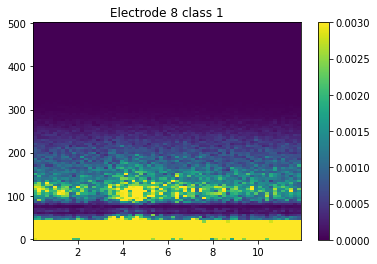

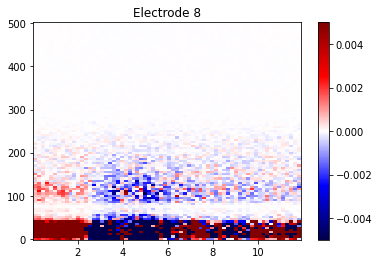

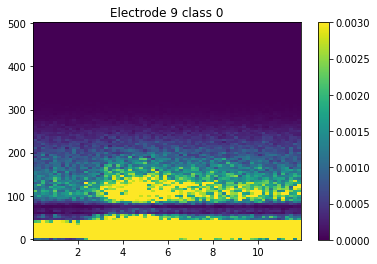

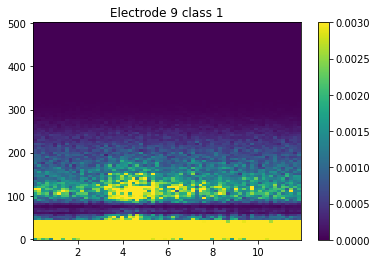

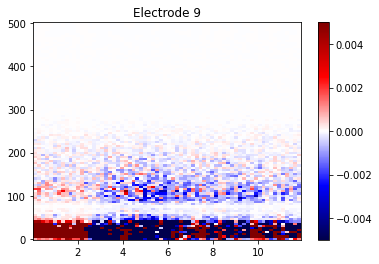

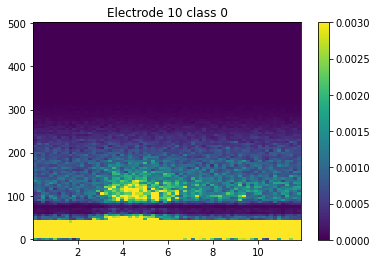

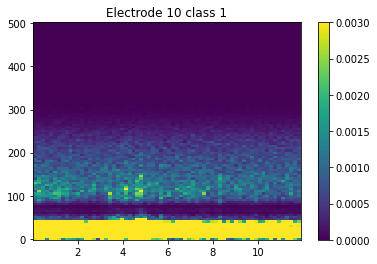

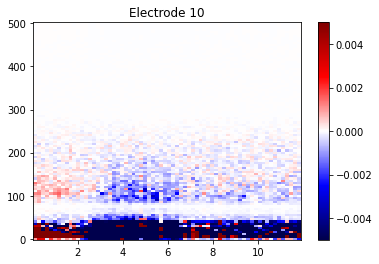

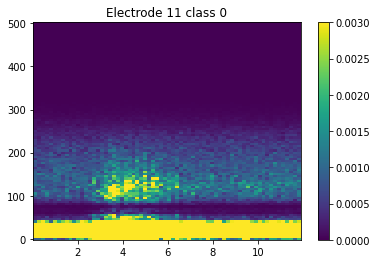

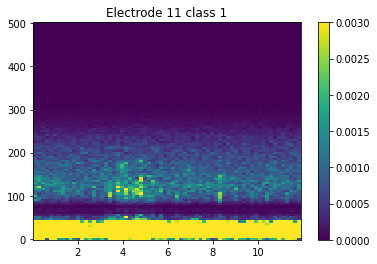

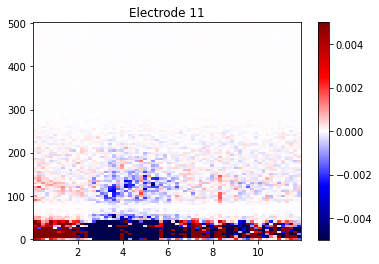

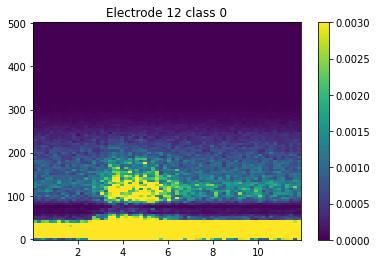

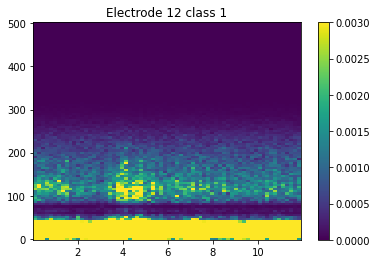

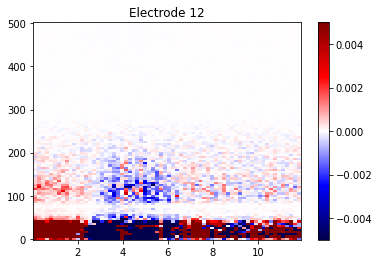

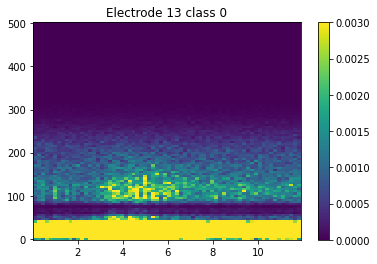

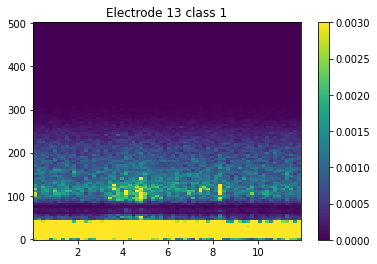

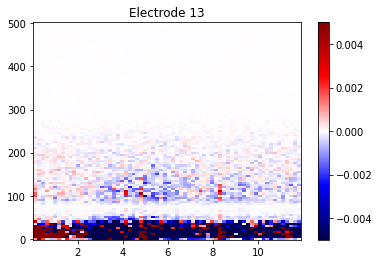

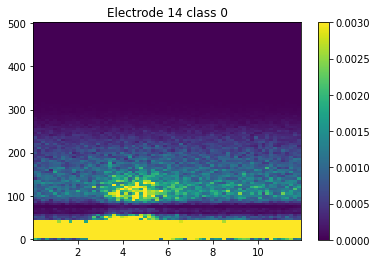

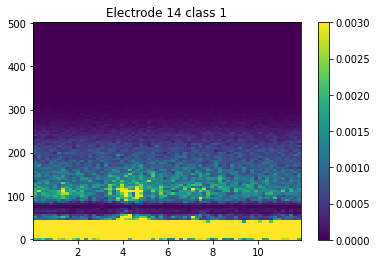

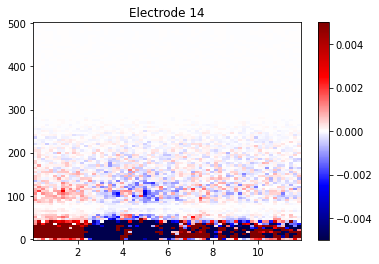

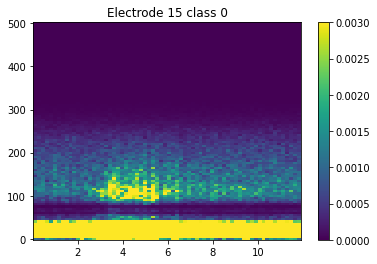

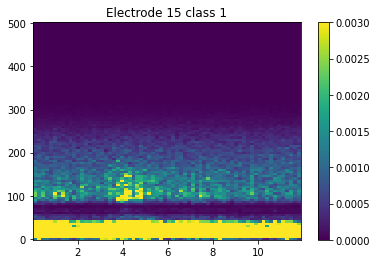

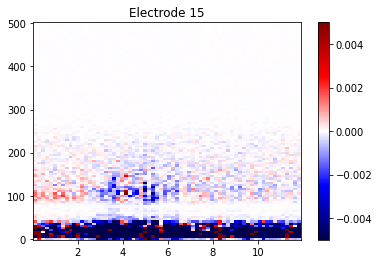

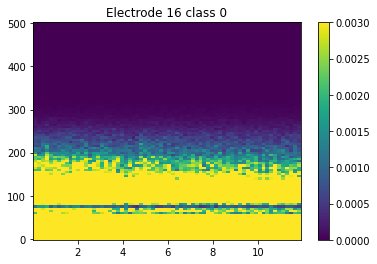

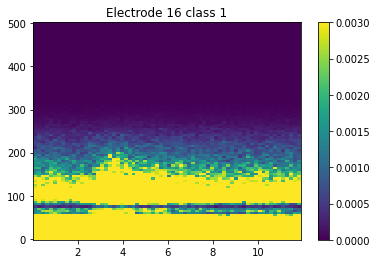

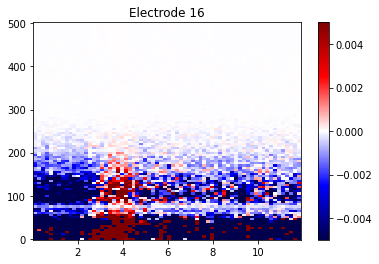

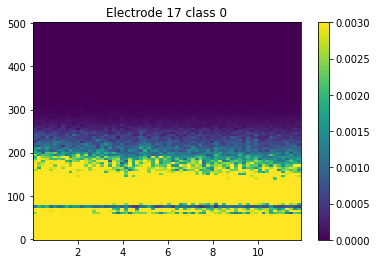

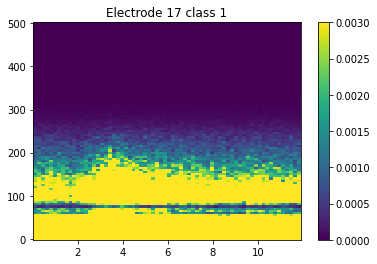

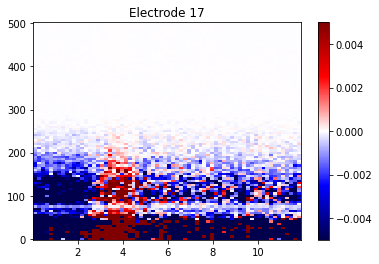

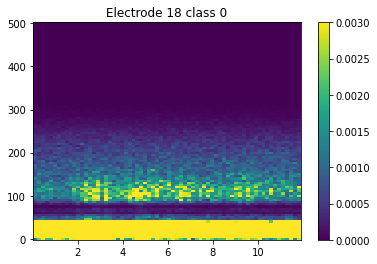

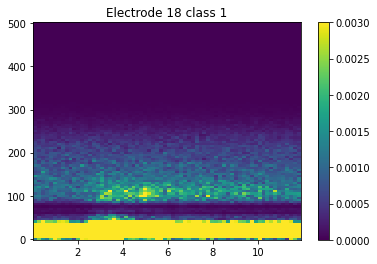

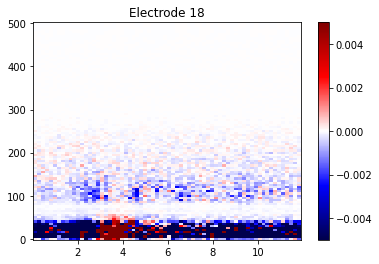

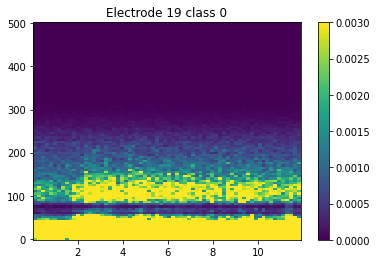

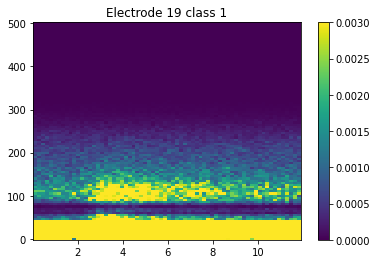

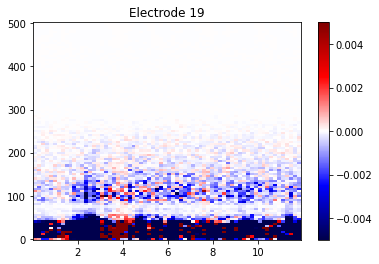

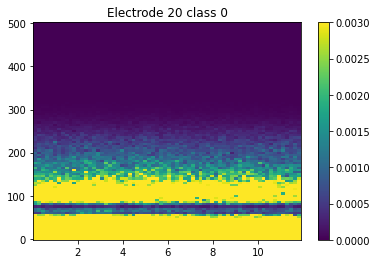

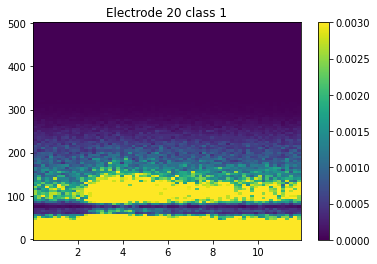

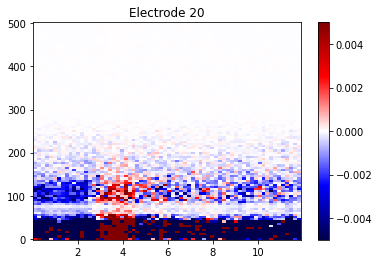

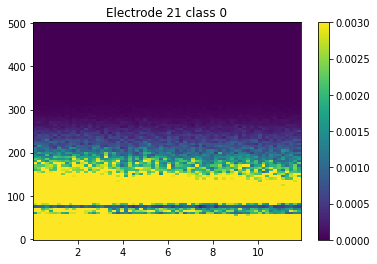

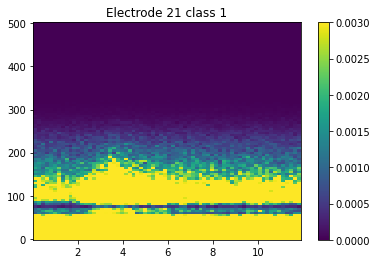

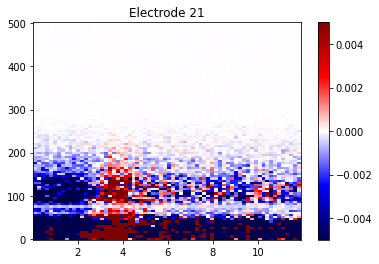

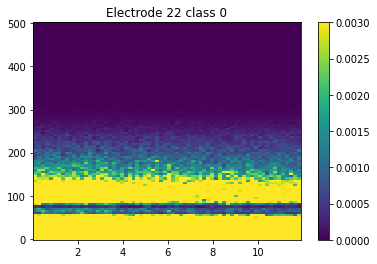

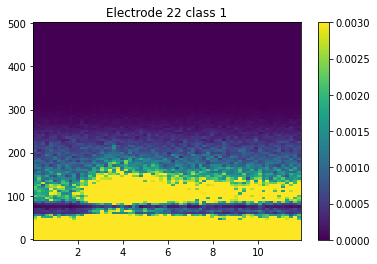

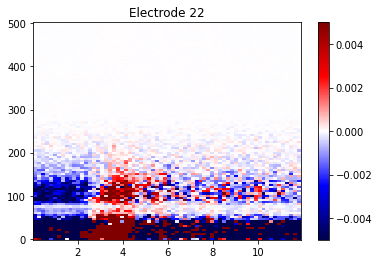

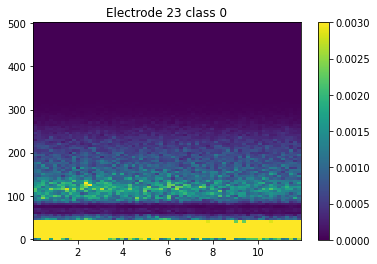

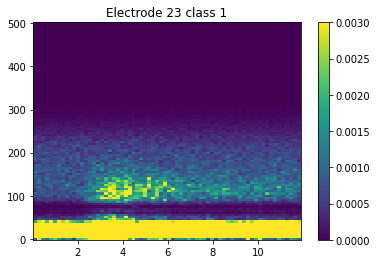

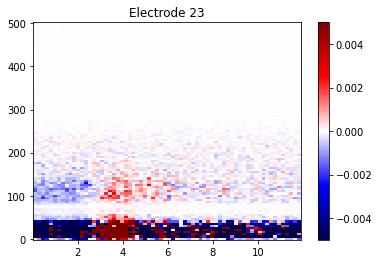

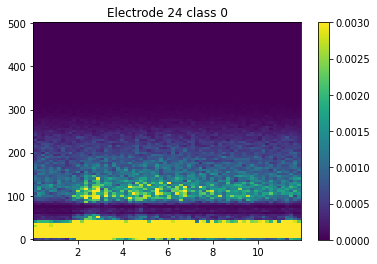

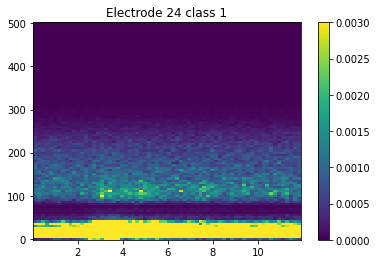

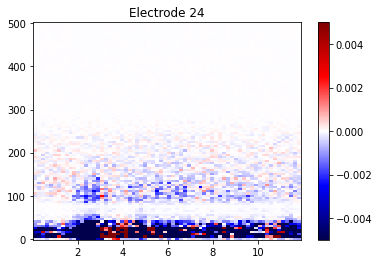

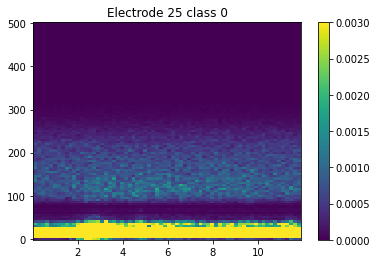

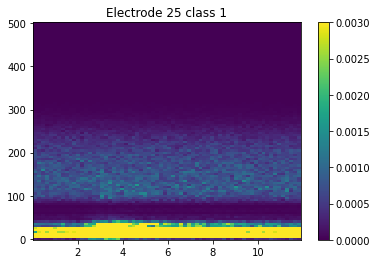

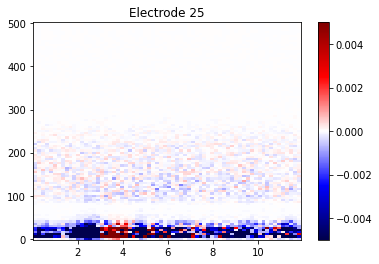

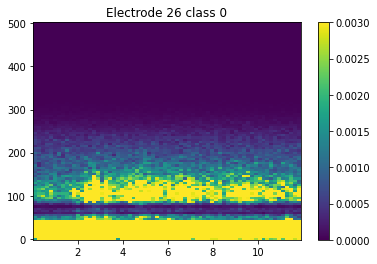

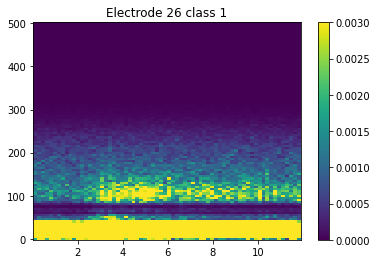

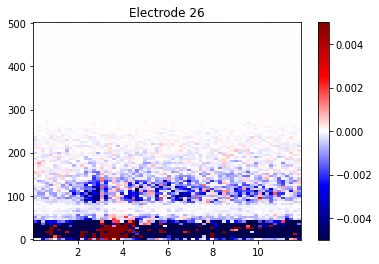

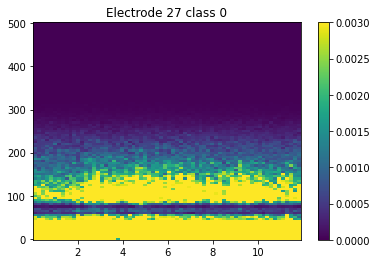

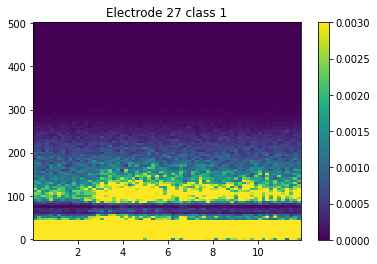

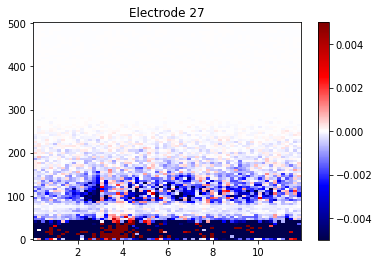

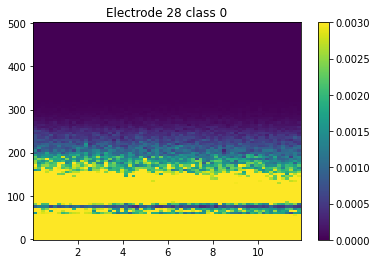

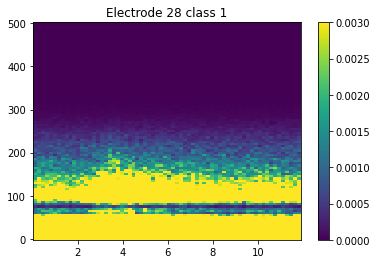

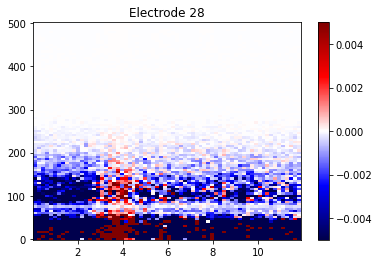

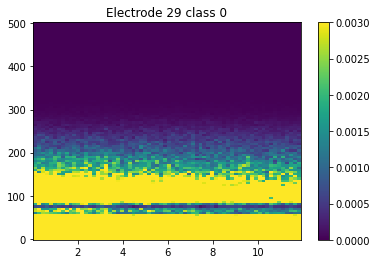

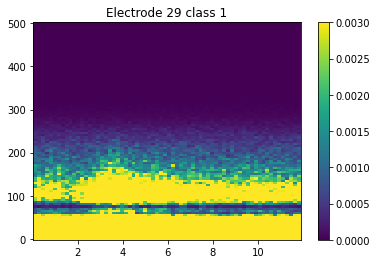

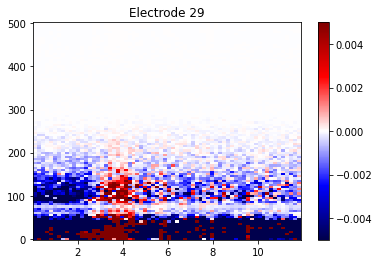

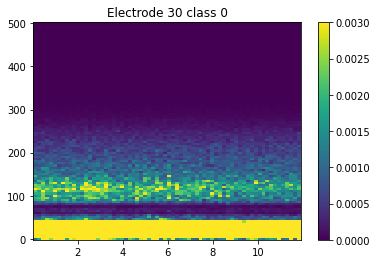

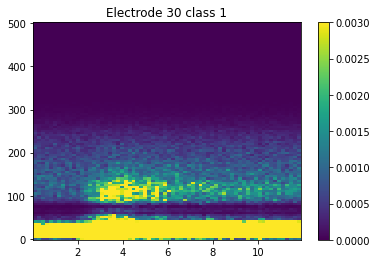

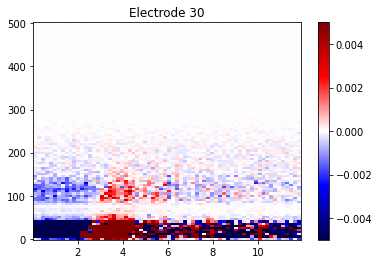

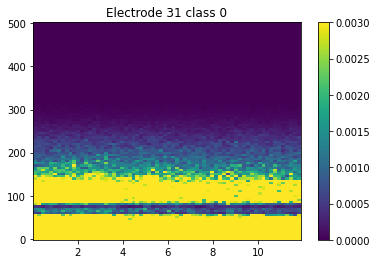

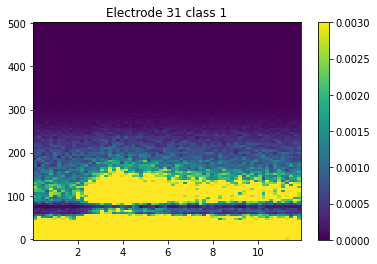

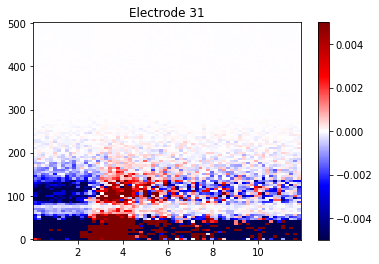

In [22]:
from scipy import signal

#print(data['key_label'][0])

tot = [0]*32
tot1 = [0] * 32
found = [False]*32
found1 = [False]*32
count = 0
count1 = 0

for i in range(0, 79):
    for j in range (0, 32):
        #print(i)
        if(data['key_label'][i] == 0):
            f, t, Sxx = signal.spectrogram(data['full_windows'][i][:, j],fs= 1000, axis=0, nperseg = 200)
            #plt.pcolormesh(t, f, Sxx, shading='gouraud')
            #plt.show()
            count += 1
            if(found[j] == False):
                found[j] = True
                tot[j] = Sxx
            else:
                tot[j] += Sxx
                
        if(data['key_label'][i] == 2):
            f1, t1, Sxx = signal.spectrogram(data['full_windows'][i][:, j],fs= 1000, axis=0, nperseg=200)
            #plt.pcolormesh(t, f, Sxx, shading='gouraud')
            #plt.show()
            count1 += 1
            if(found1[j] == False):
                found1[j] = True
                tot1[j] = Sxx
            else:
                tot1[j] += Sxx

for i in range(0, 32):
    tot[i] = tot[i]/count
    tot1[i] = tot1[i]/count1
    
for i in range(0, 32):
    plt.pcolormesh(t, f, tot[i], shading='auto', vmin = 0, vmax = 0.003)
    plt.title("Electrode " + str(i) + " class 0")
    plt.colorbar()
    plt.show(block=False)
    
    plt.pcolormesh(t1, f1, tot1[i], shading='auto', vmin = 0, vmax = 0.003)
    plt.title("Electrode " + str(i) + " class 1")
    plt.colorbar()
    plt.show(block=False)
    
    plt.pcolormesh(t, f, tot1[i] - tot[i], shading='auto', cmap='seismic', vmin = -.005, vmax = .005)
    plt.title("Electrode " + str(i))
    plt.colorbar()
    plt.show(block=False)

In [77]:
config = load_config("/home/john/emg_decoder/configs/keydecoder.yaml")
train_data, val_test_data = train_test_split(data,
                                            train_size=0.8,
                                            stratify=data['key_label'],
                                            random_state=config['random_seed'])

relative_val_proportion = config['data']['val_proportion'] / (1 - config['data']['train_proportion'])

val_data, test_data = train_test_split(val_test_data,
                                      train_size=0.1,
                                       stratify=val_test_data['key_label'],
                                       random_state=config['random_seed'])

train_dataset = KeyDataset(None, None, None, None, None, subwindow_len, init=False, binary=False)
train_dataset.full_windows = train_data['full_windows']
train_dataset.X = train_data['emg_windows']
train_dataset.y = train_data['key_label']
train_dataset.num_chans = train_dataset.X.shape[-1]


train_dataset.print_counts()
# train_dataset.balance_classes(var_factor=3, time_shift=True, add_noise=True)
target = 2000
for class_id in np.unique(train_dataset.y):
    train_dataset.augment_class(class_id, target_num_samples=target, var_factor=3, time_shift=True, add_noise=True
                                , in_place=True)
# train_dataset.augment_class(0, num_views=3, var_factor=3, time_shift=True, add_noise=True, in_place=True)
# train_dataset.augment_class(1, num_views=6, var_factor=3, time_shift=True, add_noise=True, in_place=True)
train_dataset.print_counts()
train_data = train_dataset.to_numpy(include_full_windows=False)

0.0, NULL: 1975
1.0, : 257
0.0, NULL: 3975
1.0, : 2257


In [78]:
name = expt_names[0] + "_binary_noised"

print(name)
print(train_dataset.to_numpy(include_full_windows=False).size, val_data.size, test_data.size)
processed_data_dir = "/home/john/emg_decoder/data/processed/"
train_path = processed_data_dir + name + "_train.npy"
val_path = processed_data_dir + name + "_val.npy"
test_path = processed_data_dir + name + "_test.npy"
path = processed_data_dir + name
np.save(train_path, train_dataset.to_numpy(include_full_windows=False))
np.save(val_path, val_data)
np.save(test_path, test_data)

config['model']['loss'] = 'CrossEntropyLoss'
config['data']['train_path'] = train_path
config['data']['val_path'] = val_path
config['data']['test_path'] = test_path
config['data']['window_length'] = subwindow_len
config['name'] = name
config['root_dir'] = "/home/john/emg_decoder"

Jacob_2024-02-22-1550_Open-Loop-Typing-Task_binary_noised
6232 55 503


In [79]:
system_type = KeyDecoder
experiment_dir = f"/home/john/emg_decoder/models/{config['name']}"
accelerator = 'cuda'
devices = [0]


system, trainer = train(
        system_type,
        config,
        experiment_dir=experiment_dir,
        accelerator=accelerator,
        devices=devices,
    
    run=True
    )

Global seed set to 4995
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/john/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /home/john/emg_decoder/models/Jacob_2024-02-22-1550_Open-Loop-Typing-Task_binary_noised/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params
--------------------------------

Sanity Checking: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])


Training: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([32, 480, 32]) torch.Size([32]) hi
x torch.Size([32, 256])
out torch.Size([32, 2])
torch.Size([

Validation: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])


In [80]:
expt = Experiment(system_type, experiment_dir, version=0)
expt.list_checkpoints()

Versions: ['0', '1'] available, loading version 0...


['bell-epoch=28-val_loss=0.00.ckpt',
 'Jacob_2024-02-22-1550_Open-Loop-Typing-Task_binary_noised.pt',
 'bell-epoch=09-val_loss=0.00.ckpt',
 'bell-epoch=24-val_loss=0.00.ckpt',
 'bell-epoch=23-val_loss=0.00.ckpt',
 'last.ckpt',
 'bell-epoch=27-val_loss=0.00.ckpt',
 'bell-epoch=29-val_loss=0.00.ckpt',
 'bell-epoch=18-val_loss=0.00.ckpt',
 'bell-epoch=22-val_loss=0.00.ckpt',
 'last-v1.ckpt',
 'bell-epoch=14-val_loss=0.00.ckpt',
 'bell-epoch=30-val_loss=0.00.ckpt']

In [81]:
system.load_from_checkpoint(experiment_dir + "/models/" + "bell-epoch=30-val_loss=0.00.ckpt")
trainer.test(system)
out = trainer.predict(system)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
───────────────────────────────────────────────────────────────────

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([32, 256])
out torch.Size([32, 2])
x torch.Size([23, 256])
out torch.Size([23, 2])


In [83]:
Xs = np.concatenate([a[0] for a in out])
ys = np.concatenate([a[1] for a in out])
print(Xs.shape, ys.shape)
preds = np.hstack([torch.argmax(a[0], axis=1) for a in out])
# print(Xs)
# preds = np.hstack([torch.round(torch.nn.functional.sigmoid(a[0])) for a in out])
# print(preds)

(503, 2) (503,)


In [84]:
typing_test_layout = [65505, 'a', 'w', 'd', ' ', 'j', 'i', 'o', ';']
#layout = ['a', 's', 'd', 'f', 'j', 'i', 'o', ';', ' ', 'k', 'l']
layout = ['j', 'k', 'l', ';']
asciis = [ord(ch) if type(ch) == str else ch for ch in comb_layout]
print(asciis)
#idxs = np.argsort(asciis)
idxs = [0, 5, 2, 3, 4, 1]
print(np.argsort(asciis))
print(np.unique(ys))
reord_ys = np.array([idxs[i] for i in ys])
reord_preds = np.array([idxs[i] for i in preds])

print(preds)
print(reord_preds)

[97, 115, 100, 102, 103, 98]
[0 5 2 3 4 1]
[0 1]
[1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

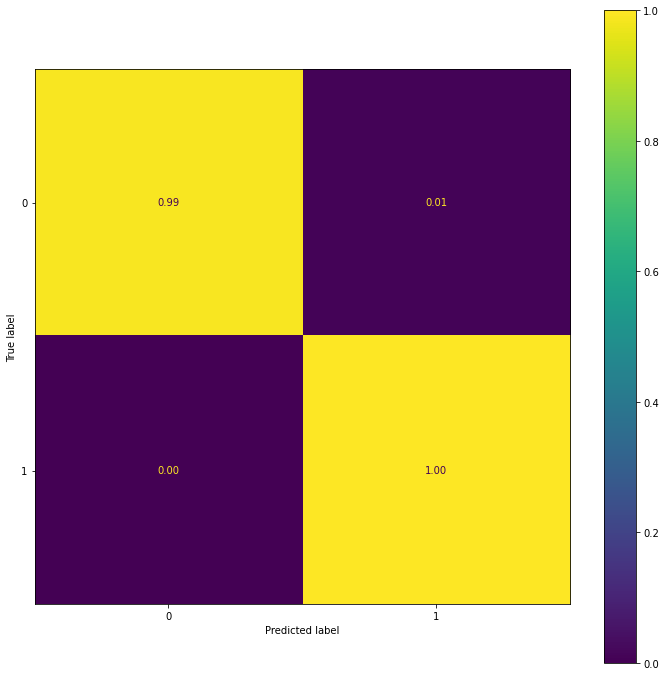

In [85]:
disp = ConfusionMatrixDisplay.from_predictions(ys, preds, normalize='true', values_format='.2f',
                                               )


[97.0, 100.0, 102.0, 115.0]


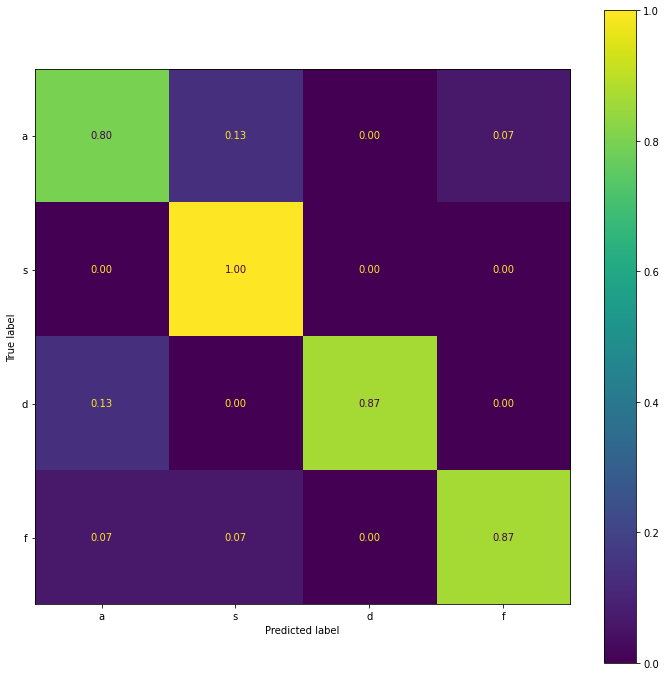

In [69]:
plt.rcParams["figure.figsize"] = (12, 12)
classes = system.classes
print(classes)
classes = [ord('a'), ord('s'), ord('d'), ord('f')]
#classes = [ord('d'), ord('f'), ord('j'), ord('k'), ord('l'), ord(';')]
#classes = [ord("a"), ord('s'), ord('d'), ord('f'), ord(" "), ord('j'), ord('k'), ord('l'), ord(';')]
#lasses = [ord('j'), ord('k'), ord('l') ,ord(';')]
#classes = [ord('a'), ord('s'), ord('d'), ord('f'), ord('g'), ord('b')]
labels = [chr(int(c)) for c in classes]
disp = ConfusionMatrixDisplay.from_predictions(reord_ys, reord_preds, normalize='true', values_format='.2f',
                                               display_labels=[chr(int(i)) for i in classes])


In [86]:
torch.save(system.state_dict(), f"{experiment_dir}/models/{config['name']}.pt")

In [87]:
print(f"{experiment_dir}/models/{config['name']}.pt")

/home/john/emg_decoder/models/Jacob_2024-02-22-1550_Open-Loop-Typing-Task_binary_noised/models/Jacob_2024-02-22-1550_Open-Loop-Typing-Task_binary_noised.pt


In [32]:
      experiment_directory: /home/john/emg_decoder/models/Jacob_2023-10-30-1648_Open-Loop-Typing-Task_typing_pacman_left_corrected1
      checkpoint_name: Jacob_2023-10-30-1648_Open-Loop-Typing-Task_typing_pacman_left_corrected1.pt

SyntaxError: invalid decimal literal (801240738.py, line 1)

In [ ]:
      experiment_directory: /home/john/emg_decoder/models/Jacob_2023-10-30-1648_Open-Loop-Typing-Task_typing_pacman_left_binary
      checkpoint_name: Jacob_2023-10-30-1648_Open-Loop-Typing-Task_typing_pacman_left_binary.pt

In [ ]:
      experiment_directory: /home/john/emg_decoder/models/Jacob_2023-11-17-1130_Open-Loop-Typing-Task_binary
      checkpoint_name: Jacob_2023-11-17-1130_Open-Loop-Typing-Task_binary.pt
        
    experiment_directory: /home/john/emg_decoder/models/Jacob_2023-11-17-1130_Open-Loop-Typing-Task_typing_3
      checkpoint_name: Jacob_2023-11-17-1130_Open-Loop-Typing-Task_typing_3.pt